In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

from glob import glob
import json
import csv
import os

import cv2
import numpy as np

In [3]:
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import LeakyReLU, ELU, Dropout

Using TensorFlow backend.


In [4]:
from keras.optimizers import Adam
from keras.layers import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
from utils import read_samples
from utils import ImageGenerator
from utils import CenterImageGenerator

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from keras import regularizers
from keras.layers import Activation

In [8]:
from keras.layers import AveragePooling2D

In [9]:
ROOT_DIR = os.path.join(os.getcwd(), '../')
DATA_DIR = os.path.join(ROOT_DIR, 'data')

In [10]:
samples = read_samples(DATA_DIR)
samples.pop(0)

Loaded 8037 samples.


['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

In [11]:
def append_path(line):
    line[0] = os.path.join(DATA_DIR, 'sample-data', line[0].strip())
    line[1] = os.path.join(DATA_DIR, 'sample-data', line[1].strip())
    line[2] = os.path.join(DATA_DIR, 'sample-data', line[2].strip())
    return line

In [12]:
samples = [append_path(line) for line in samples]

In [13]:
samples[0]

['/home/carnd/CarND-Behavioral-Cloning-P3/notebooks/../data/sample-data/IMG/center_2016_12_01_13_30_48_287.jpg',
 '/home/carnd/CarND-Behavioral-Cloning-P3/notebooks/../data/sample-data/IMG/left_2016_12_01_13_30_48_287.jpg',
 '/home/carnd/CarND-Behavioral-Cloning-P3/notebooks/../data/sample-data/IMG/right_2016_12_01_13_30_48_287.jpg',
 ' 0',
 ' 0',
 ' 0',
 ' 22.14829']

In [14]:
train_set, test_set = train_test_split(samples, test_size=0.1)
train_set, valid_set = train_test_split(train_set, test_size=0.1)

In [16]:
train_iterator = ImageGenerator(train_set, batch_size=128, corr=0.2)
valid_iterator = CenterImageGenerator(valid_set, batch_size=128)
test_iterator = CenterImageGenerator(test_set, batch_size=128)

In [17]:
def comma_model():
    ch, row, col = 1, 70, 320  # camera format
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Conv2D(8, (8, 8), strides=(4, 4), padding="same"))
    model.add(ELU())
    model.add(Conv2D(16, (5, 5), strides=(2, 2), padding="same"))
    model.add(ELU())
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
    # model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(256))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))
    adam = Adam(0.001)
    model.compile(optimizer=adam, loss="mse")
    return model

In [18]:
model = comma_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 70, 320, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 80, 8)         520       
_________________________________________________________________
elu_1 (ELU)                  (None, 18, 80, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 40, 16)         3216      
_________________________________________________________________
elu_2 (ELU)                  (None, 9, 40, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 20, 32)         12832     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
__________

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, 
                               patience=2, verbose=1, mode='auto')
filepath = 'comma.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                save_weights_only=False, mode='auto', period=1)

In [20]:
model.fit_generator(generator=train_iterator, epochs=10, 
                    validation_data=valid_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_steps=len(valid_iterator),
                    callbacks=[checkpoint, early_stopping]
                   )

Epoch 1/10
306/306 [==============================] - 70s - loss: 0.1089 - val_loss: 0.0168
Epoch 2/10
306/306 [==============================] - 67s - loss: 0.0335 - val_loss: 0.0175
Epoch 3/10
306/306 [==============================] - 67s - loss: 0.0298 - val_loss: 0.0166
Epoch 4/10
306/306 [==============================] - 67s - loss: 0.0279 - val_loss: 0.0191
Epoch 5/10
306/306 [==============================] - 67s - loss: 0.0263 - val_loss: 0.0145
Epoch 6/10
306/306 [==============================] - 67s - loss: 0.0253 - val_loss: 0.0160
Epoch 7/10
306/306 [==============================] - 66s - loss: 0.0241 - val_loss: 0.0174
Epoch 8/10
306/306 [==============================] - 67s - loss: 0.0240 - val_loss: 0.0136
Epoch 9/10
306/306 [==============================] - 67s - loss: 0.0229 - val_loss: 0.0157
Epoch 10/10
306/306 [==============================] - 67s - loss: 0.0221 - val_loss: 0.0175


In [21]:
from keras.models import load_model
model = load_model('comma.07-0.01.hdf5')

In [22]:
results = model.evaluate_generator(generator=test_iterator, steps=len(test_iterator))

In [23]:
results

0.012270547582634858

In [ ]:
def random_shear(image, steering, shear_range=200):
    rows, cols, _ = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)  
    return image, steering + dsteering

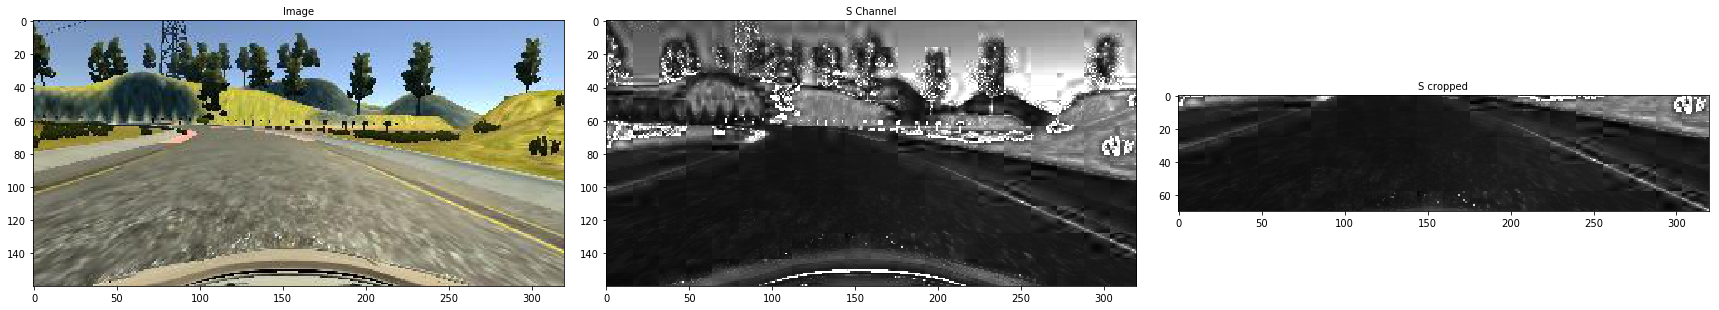

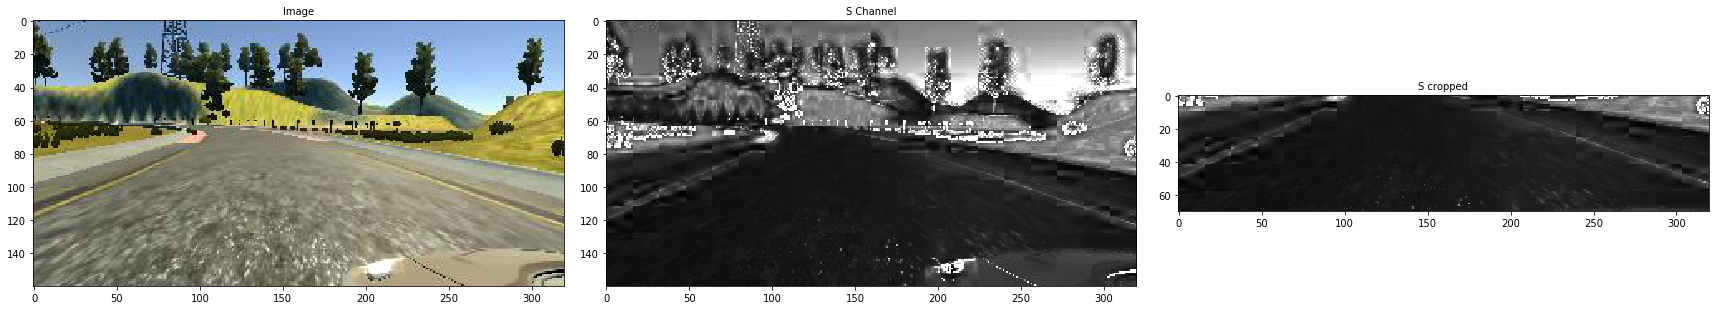

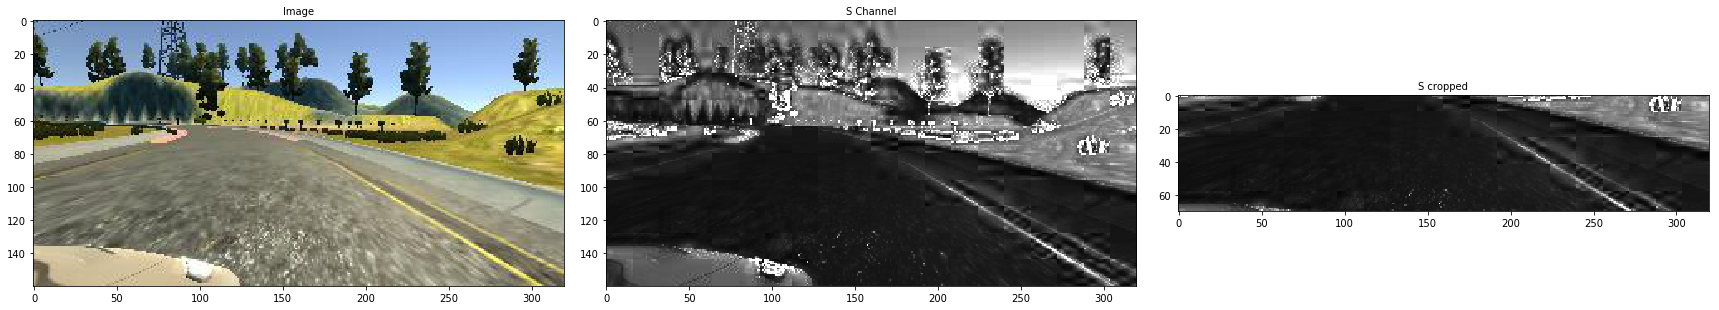

In [25]:
test_sample = np.random.choice(len(samples))
for img_path in samples[test_sample][:3]:
    image = cv2.imread(img_path)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    s = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:, : ,2]
    crop = s[70:140, :]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(rgb)
    ax1.set_title('Image', fontsize=10)
    ax2.imshow(s, cmap='gray')
    ax2.set_title('S Channel', fontsize=10)
    ax3.imshow(crop, cmap='gray')
    ax3.set_title('S cropped', fontsize=10)

In [ ]:
test_image = samples[0][0]
image = cv2.imread(test_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
warped, wangle = random_shear(image, float(samples[0][3]))
plt.imshow(warped)

In [ ]:
wangle

In [ ]:
h,w,_ = image.shape
horizon = 2*h/5
v_shift = np.random.randint(-h/8,h/8)
pts1 = np.float32([[0,horizon],[w,horizon],[0,h],[w,h]])
pts2 = np.float32([[0,horizon+v_shift],[w,horizon+v_shift],[0,h],[w,h]])
M = cv2.getPerspectiveTransform(pts1,pts2)
new_img = cv2.warpPerspective(image,M,(w,h), borderMode=cv2.BORDER_REPLICATE)

In [ ]:
plt.imshow(new_img)

In [ ]:
plt.imshow(image[70:140])

In [ ]:
plt.imshow(cv2.resize(image[70:140], (32, 16), interpolation=cv2.INTER_AREA))

In [ ]:
s = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:, :, 2]
plt.imshow(s, cmap='gray')

In [ ]:
plt.imshow(s[70:140], cmap='gray')